# Projet 10 : Détectez des faux billets avec R ou Python

# Partie 2

La partie 3 concerne la mise en place d'un clustering pour répartir les données en 2 clusters, un pour les vrais et un pour les faux billets. On va tout d'abord réaliser une ACP qui nous permettra de visualiser notre jeu de données. Ensuite on mettra en place un clustering avec les méthodes Hiérarchique et Kmeans. On terminera par la réalisation de l'algorithme de différenciation.

# Sommaire
* [Importation des librairies](#Importation_des_librairies)
* [Importation des données](#Importation_des_données)
* [ACP](#acp)
* [Clustering hiérarchique](#clustering_hiérarchique)
    * [ Traitement des Données](#données_1)
    * [Projection](#données_1_f1)
* [Kmeans](#kmeans)
    * [Traitement des Données](#données_1_2)
    * [Projection](#données_1_f1_2)
* [Comparaison des clusterings](#comparaison_des_clusterings)
* [Algorithme](#Algorithme)

# Importations des libraires<a class="anchor" id="Importation_des_librairies"></a>

In [1]:
# Importation des librairies

# Mulitpurpose
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import matplotlib.image as mpimg

# Clustering & ACP
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import confusion_matrix

# Fonctions
from functions import *

## Importation des données<a class="anchor" id="Importation_des_données"></a>

In [2]:
# Importation des données
billets_data_3 =  pd.read_csv("billets_data_3.csv", sep=",")
genuine = billets_data_3.is_genuine
billets_data_3 = billets_data_3.drop(columns=["is_genuine"])
billets_production =  pd.read_csv("billets_production.csv", sep=",")

## ACP<a class="anchor" id="acp"></a>

In [3]:
# préparation des données
X = billets_data_3.values
names = billets_data_3.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


b_data_scaled = pd.DataFrame(X_scaled,
                  index=billets_data_3.index,
                  columns=billets_data_3.columns)

# Calcul des composantes principales
n_comp = 6
pca = decomposition.PCA(n_components=n_comp)
pca.fit(b_data_scaled)

PCA(n_components=6)

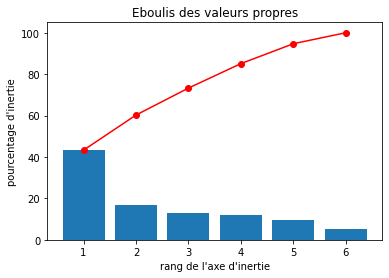

In [4]:
# Calcul du pourcentage d'inertie
display_scree_plot(pca)

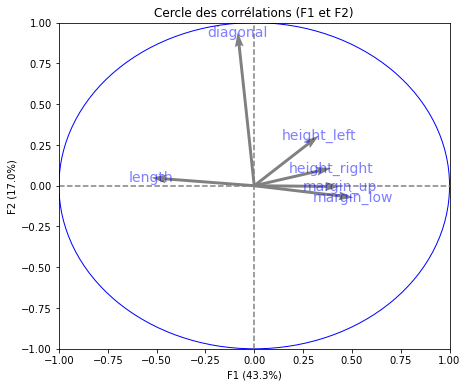

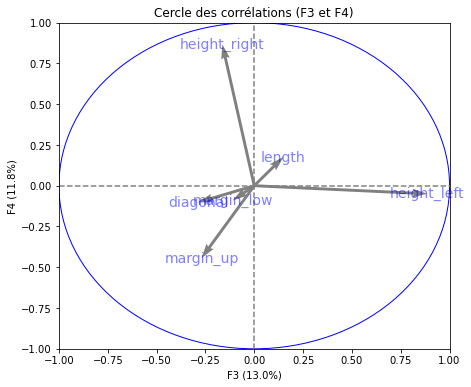

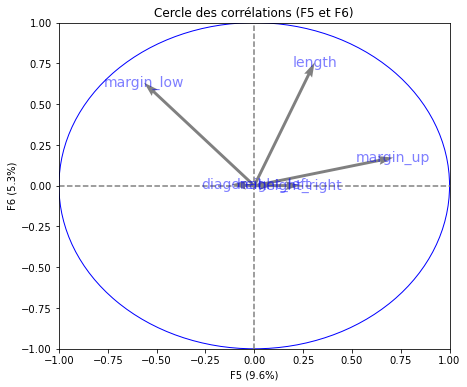

In [5]:
# Cercle des corrélations
features = b_data_scaled.columns
pcs = pca.components_
display_circles(pcs, n_comp=6, pca=pca, axis_ranks=[(0,1),(2,3),(4,5)], labels = np.array(features))

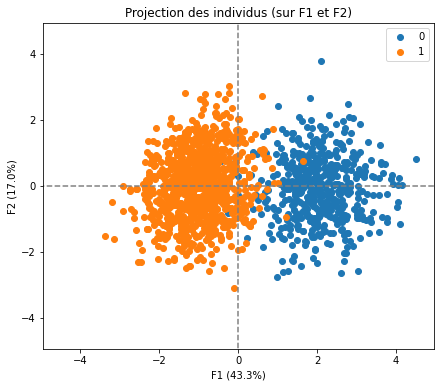

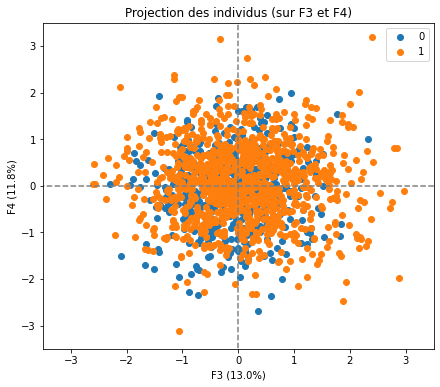

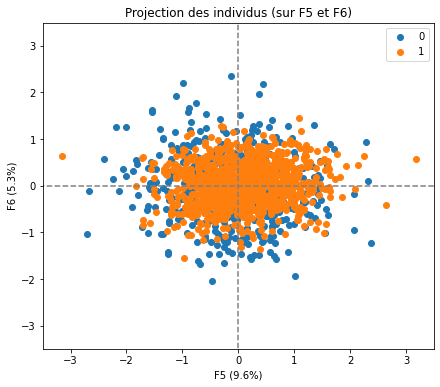

In [6]:
# Projection des individus
X_projected = pca.transform(b_data_scaled)
display_factorial_planes(X_projected, n_comp=6, pca=pca, axis_ranks=[(0,1),(2,3),(4,5)], labels=None, alpha=1, illustrative_var=genuine.values.astype(int))
plt.show()


Ici c'est seulement l'axe F1 qui nous intéresse, car c'est le seul axe sur lequel on peut faire la différence entre les vrais et les faux billets.

## Clustering Hiérarchique<a class="anchor" id="clustering_hiérarchique"></a>

### Traitement des Données<a class="anchor" id="données_1"></a>

On calcule le silhouette score pour confirmer que le bon nombre de clusters est bien 2.

Number of clusters from 2 to 9: 
 [2, 3, 4, 5, 6, 7, 8, 9]
For n_clusters = 2, silhouette score is 0.3427482010317296)
For n_clusters = 3, silhouette score is 0.21042344698755175)
For n_clusters = 4, silhouette score is 0.19603395274513824)
For n_clusters = 5, silhouette score is 0.15661771285406886)
For n_clusters = 6, silhouette score is 0.14833922377239786)
For n_clusters = 7, silhouette score is 0.1446166841092548)
For n_clusters = 8, silhouette score is 0.14291880964181777)
For n_clusters = 9, silhouette score is 0.1437920031725197)


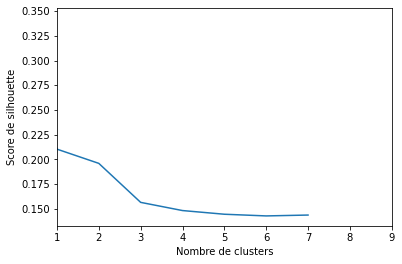

In [7]:
#Calcule le coefficient de silhouette pour un nombre de clusters de 2 à 9
range_n_clusters = list (range(2,10))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)
s_score = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(b_data_scaled)
    centers = clusterer.cluster_centers_
    score = silhouette_score(b_data_scaled, preds)
    s_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(s_score)
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
ax=plt.gca()
ax.set_xlim(1,9)
plt.show()

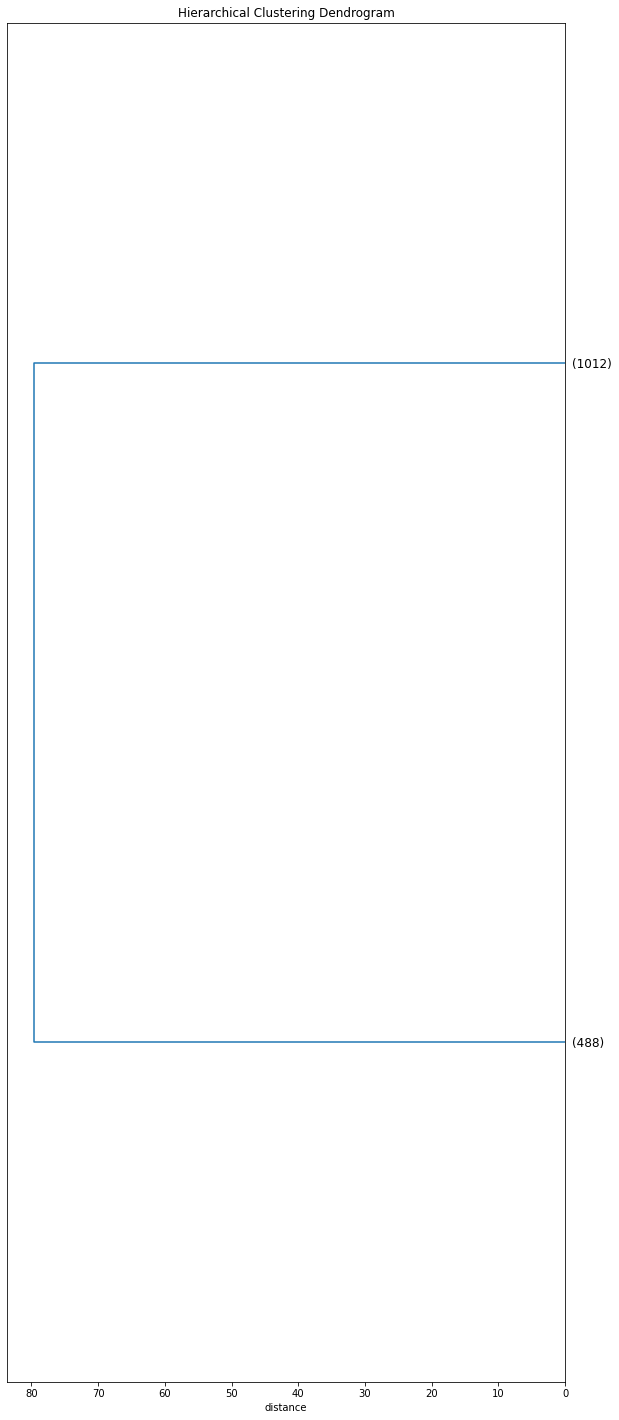

In [8]:
# Clustering hiérarchique
Z = linkage(b_data_scaled, method='ward', metric='euclidean')

#Affiche le dendogram sur 5 lignes
plt.figure(figsize=(10,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(
    Z,
    p=2,
    truncate_mode="lastp",
    labels = names,
    orientation = "left",
)
plt.show()

In [9]:
# Coupage du dendrogramme en 2 clusters
clusters = fcluster(Z, 2, criterion='maxclust')
# Change les numéros des clusters pour match ceux du Kmeans
clusters=np.where(clusters==1,0,clusters)
clusters=np.where(clusters==2,1,clusters)
classes = pd.DataFrame({"cluster": clusters})
#Créé une table avec les moyennes de chaque indicateur pour chaque cluster
billets_data_5 = pd.merge(b_data_scaled, classes, left_index=True, right_index=True)

In [10]:
#Affiche les résultats du clustering
résulats_clustering = billets_data_5.groupby("cluster").mean()
résulats_clustering

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,-0.204175,0.545407,0.706693,1.142149,0.870754,-1.217728
1,0.098456,-0.263003,-0.340777,-0.550759,-0.419889,0.587205


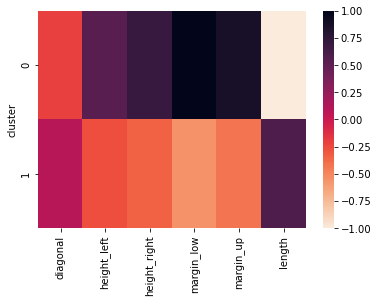

In [11]:
#Affiche les résultats du clustering sous forme de heatmap
Heatmap = sb.heatmap(data=résulats_clustering, vmin=-1, vmax=1, cmap="rocket_r")

Diagonal mis à part, on remarque un très fort contraste entre les centroïdes des clusters pour chaque donnée.

In [12]:
# Crosstab pour vérifier si les billets sont bien classés
billets_data_5 = pd.merge(billets_data_5, genuine, left_index=True, right_index=True)
conf_cah = pd.crosstab(billets_data_5.cluster, billets_data_5.is_genuine, normalize="columns")
conf_cah*100

is_genuine,False,True
cluster,,
0,96.8,0.4
1,3.2,99.6


### Projection <a class="anchor" id="données_1_f1"></a>

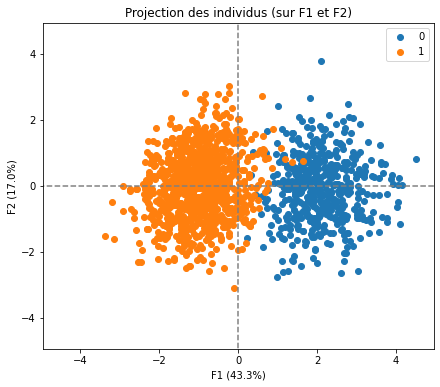

<Figure size 432x288 with 0 Axes>

In [13]:
# Projection des individus
X_projected = pca.transform(b_data_scaled)
display_factorial_planes(X_projected, n_comp=2, pca=pca, axis_ranks=[(0,1)], labels=None, alpha=1, illustrative_var=billets_data_5["cluster"])
plt.savefig("Projection_cah.png")
plt.show()

## Kmeans<a class="anchor" id="kmeans"></a>

### Traitement des Données<a class="anchor" id="données_1_2"></a>

On trace le graphique du coude pour confirmer que le bon nombre de clusters est bien 2.

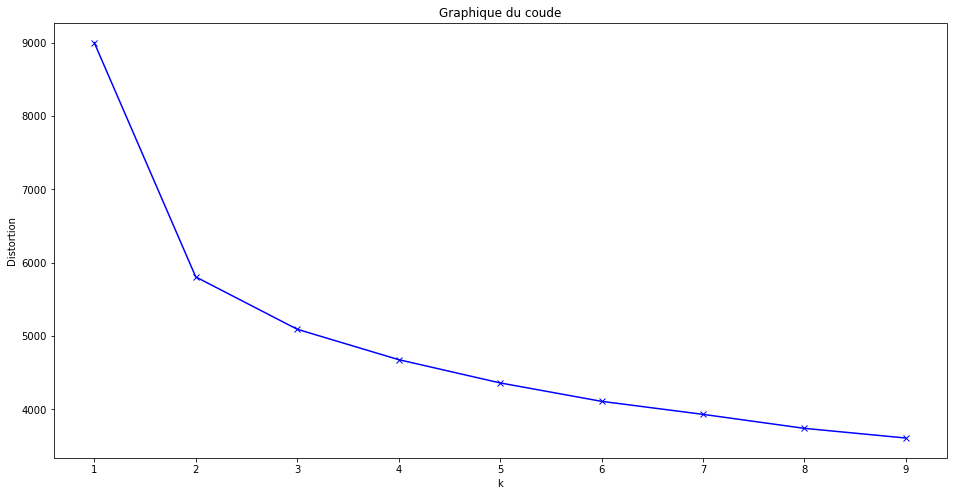

In [14]:
#Calcule le graphique du coude pour déterminer le nombre idéal de clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(b_data_scaled)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Graphique du coude')
plt.show()

In [15]:
#Effectue le clustering Kmeans
kmeans = KMeans(n_clusters=2, n_init= 100, random_state = 10).fit(b_data_scaled)

#Centroids du Kmeans
centroids_k = kmeans.cluster_centers_

#Labels du Kmeans
kmeans_labels = kmeans.labels_
#kmeans_labels=np.where(kmeans_labels==0,2,kmeans_labels)

#Créé une nouvelle table avec les clusters du Kmeans
billets_data_6 = b_data_scaled

billets_data_6["cluster"] = kmeans_labels
billets_data_6["is_genuine"] = genuine.values
#Drop la colonne cluster de la table originale
b_data_scaled = b_data_scaled.drop(columns=["cluster", "is_genuine"])

In [16]:
# Crosstab pour vérifier si les billets sont bien classés
conf_kmeans = pd.crosstab(billets_data_6.cluster, billets_data_6.is_genuine, normalize="columns")
billets_data_6=billets_data_6.drop(columns=["is_genuine"])
conf_kmeans*100

is_genuine,False,True
cluster,,
0,97.2,1.0
1,2.8,99.0


In [17]:
#Affiche les résultats du clustering
résulats_clustering = billets_data_6.groupby("cluster").mean()
résulats_clustering

,diagonal,height_left,height_right,margin_low,margin_up,length
cluster,,,,,,
0,-0.194323,0.570713,0.713365,1.118261,0.864176,-1.200833
1,0.096000,-0.281946,-0.352419,-0.552448,-0.426924,0.593240


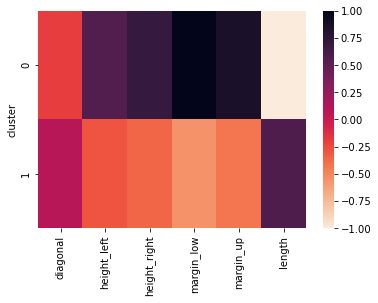

In [18]:
#Affiche les résultats du clustering sous forme de heatmap
Heatmap = sb.heatmap(data=résulats_clustering, vmin=-1, vmax=1, cmap="rocket_r")

Diagonal mis à part, on remarque un très fort contraste entre les centroïdes des clusters pour chaque donnée.

### Projection<a class="anchor" id="données_1_f1_2"></a>

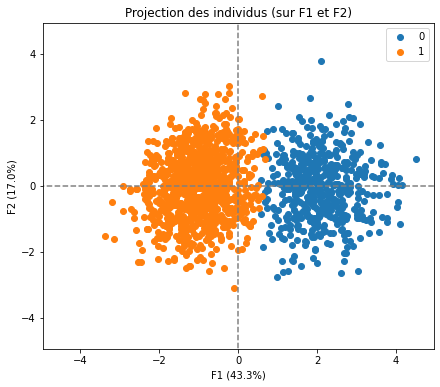

<Figure size 432x288 with 0 Axes>

In [19]:
# Projection des individus
X_projected = pca.transform(b_data_scaled)
display_factorial_planes(X_projected, n_comp=2, pca=pca, axis_ranks=[(0,1)], labels=None, alpha=1, illustrative_var=kmeans_labels)
plt.savefig("Projection_kmeans.png")
plt.show()

## Comparaison des clusterings<a class="anchor" id="comparaison_des_clusterings"></a>

In [20]:
print("Données du clustering hiérarchique en % :")
print(conf_cah*100)
print()
print("Données du Kmeans en % :")
print(conf_kmeans*100)

Données du clustering hiérarchique en % :
is_genuine  False  True 
cluster                 
0            96.8    0.4
1             3.2   99.6

Données du Kmeans en % :
is_genuine  False  True 
cluster                 
0            97.2    1.0
1             2.8   99.0


A gauche les vrais billets, à droite les faux.

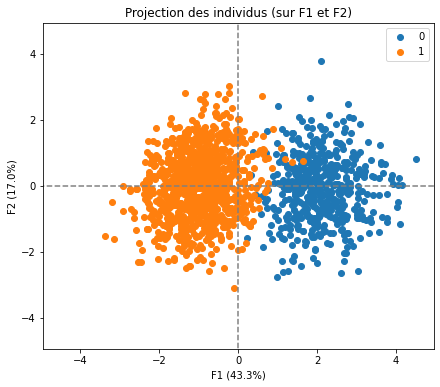

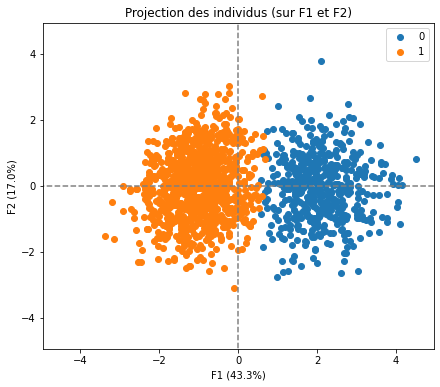

In [21]:
# Projection des individus
X_projected = pca.transform(b_data_scaled)
display_factorial_planes(X_projected, n_comp=2, pca=pca, axis_ranks=[(0,1)], labels=None, alpha=1, illustrative_var=billets_data_5["cluster"])
plt.show()
# Projection des individus
X_projected = pca.transform(b_data_scaled)
display_factorial_planes(X_projected, n_comp=2, pca=pca, axis_ranks=[(0,1)], labels=None, alpha=1, illustrative_var=kmeans_labels)
plt.show()

Les résultats des deux méthodes de clustering sont assez similaires, le Kmeans est un peu plus précis pour détecter les faux billets, mais un peu moins pour les vrais.

## Algorithme<a class="anchor" id="Algorithme"></a>

In [22]:
def detection_billet(data):
    # Créé un nouveau DataFrame et récupère les données nécessaires du DataFrame entré pour éliminer les colonnes superflues
    tab = pd.DataFrame()
    tab["diagonal"] = data["diagonal"]
    tab["height_left"] = data["height_left"]
    tab["height_right"] = data["height_right"]
    tab["margin_low"] = data["margin_low"]
    tab["margin_up"] = data["margin_up"]
    tab["length"] = data["length"]
    # préparation des données
    X = tab.values
    names = tab.index

    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    
    tab_scaled = pd.DataFrame(X_scaled,
                  index=tab.index,
                  columns=tab.columns)
    # Calcule la distance entre chaque point et chaque centroid
    clu = kmeans.predict(tab_scaled)
    tab2=data
    tab2["cluster"] = clu
    return(tab2)

In [23]:
detection_billet(billets_production)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,cluster
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


Le cluster 0 correspond au cluster des faux billets, le cluster 1 correspond à celui des vrais.

L'algorithme de détection des billets a été mis en place, il requiert en entrée un dataframe contenant les colonnes diagonal, height_left, height_right, margin_low, margin_up et length, précisemment orthographiées comme ceci. Il retourne le DataFrame entré avec une colonne supplémentaire, cluster, qui indique si les billets sont faux, cluster 0, ou vrai, cluster 1.